In [1]:
!pip install tensorflow numpy pandas seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow.keras as keras
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist

---

# Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Plotting a sample

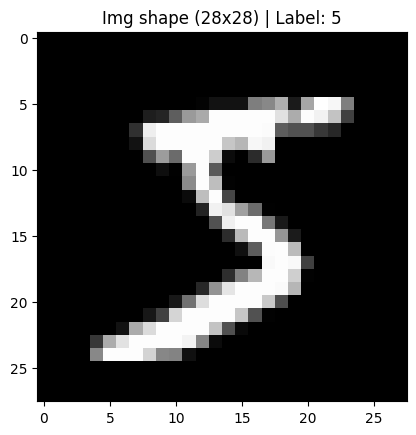

In [4]:
sample_idx = 0

plt.imshow(x_train[sample_idx], cmap='gray')
plt.title(f'Img shape ({x_train[sample_idx].shape[0]}x{x_train[sample_idx].shape[1]}) | Label: {y_train[sample_idx]}')
plt.show()

## One-hot Encoding the labels

In [5]:
y_train_oh = keras.utils.to_categorical(y_train, num_classes=10)
y_test_oh = keras.utils.to_categorical(y_test, num_classes=10)

## Flattening images

In [6]:
fltn = Flatten()

x_train = fltn(x_train)
x_test  = fltn(x_test)

## Normalizing input

In [7]:
x_train = x_train/255
x_test = x_test/255

---

# Neural Network

In [8]:
model = Sequential()
model.add(Dense(1569, activation='relu', input_dim=len(x_train[0]), name='Hidden-01'))
model.add(Dense(784, activation='relu', input_dim=1569, name='Hidden-02'))
model.add(Dense(300, activation='relu', input_dim=784, name='Hidden-03'))
model.add(Dense(100, activation='relu', input_dim=300, name='Hidden-04'))
model.add(Dense(30, activation='relu', input_dim=100, name='Hidden-05'))
model.add(Dense(10, activation='softmax', input_dim=30, name='Output'))
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        keras.metrics.CategoricalAccuracy(name='Accuracy'),
        keras.metrics.Precision(name='Precision'),
        keras.metrics.Recall(name='Recall'),
        keras.metrics.F1Score(name='F1', average='micro'),
    ]
)

model.summary()

c:\Users\12ped\anaconda3\envs\biopotenciais\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden-01 (Dense)               │ (None, 1569)           │     1,231,665 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden-02 (Dense)               │ (None, 784)            │     1,230,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden-03 (Dense)               │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden-04 (Dense)               │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden-05 (Dense)               │ (None, 30)             │         3,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,731,485 (10.42 MB)

 Trainable params: 2,731,485 (10.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def greedy_layer_wise_pre_trainining(model, training_data, val_data):
    pretrain_history = []
    
    input_shape = len(training_data[0])

    # Build a pretraining pipeline
    pretraining_model = Sequential()
    pretraining_model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mse']
    )

    # Perform the layer wise pre-training
    for layer in model.layers[:-1]:
        # Add single layer
        pretraining_model.add(layer)
        # Add dummy output layer
        pretraining_model.add(Dense(
            input_shape,  # Should output the input image
            activation='relu',  # We are doing regression of the input, so we need a regression actv. func.
            input_dim=layer.units   # input layers = # of neurons in the last layers
        ))
        # Train the model
        pretrain_history.append(pretraining_model.fit(
            x=training_data,
            y=training_data,
            batch_size=50,
            epochs=3,
            shuffle=True,
            validation_data=(val_data, val_data),
        ))

        fig, axs = plt.subplots(1, 2)
        fig.suptitle(f"Sample image reconstruction using {len(pretrain_history)} hidden layer(s)")
        axs[0].set_title("Original")
        axs[1].set_title("Predicted")
        axs[1].imshow(
            np.reshape(
                pretraining_model.predict(np.array([val_data[0]])),
                (28,28)
            ), cmap='gray')
        axs[0].imshow(np.reshape(val_data[0], (28,28)), cmap='gray')
        plt.show()
        
        # Pop dummy output layer
        pretraining_model.pop()
        # Freezes the current layer to train the next one
        layer.trainable = False

    for layer in model.layers:
        # Unfreezes everything
        layer.trainable = True
    
    return pretrain_history

Epoch 1/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 2/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 3/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0069 - val_mse: 0.0069
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


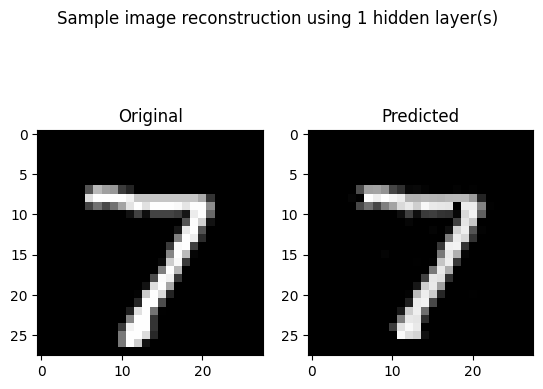

Epoch 1/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 2/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 3/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0070 - val_mse: 0.0070
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


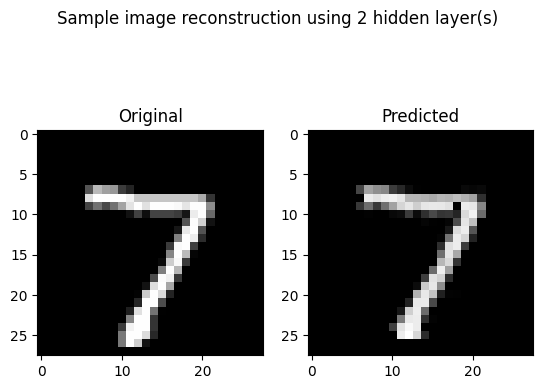

Epoch 1/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 2/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0069 - val_mse: 0.0069
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


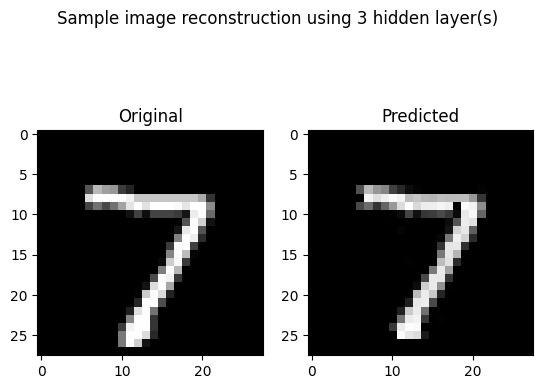

Epoch 1/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 2/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0068 - val_mse: 0.0068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


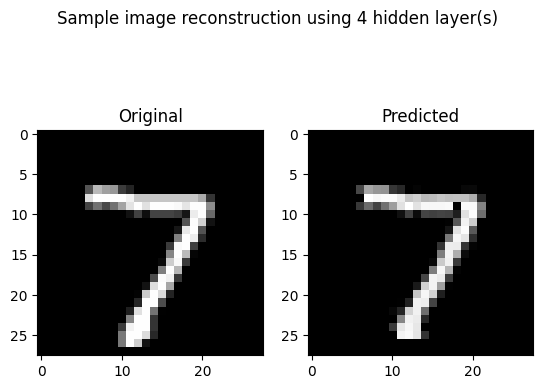

Epoch 1/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 2/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0069 - val_mse: 0.0069
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


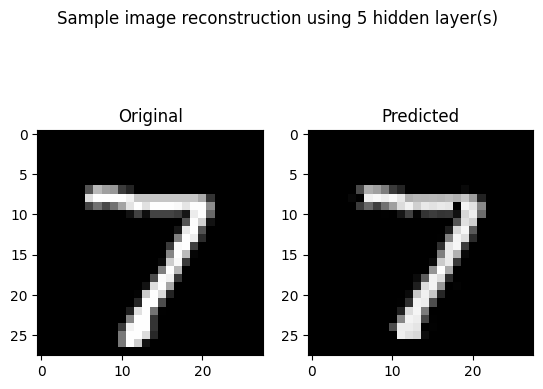

Epoch 1/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 2/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 3/3
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0068 - val_mse: 0.0068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


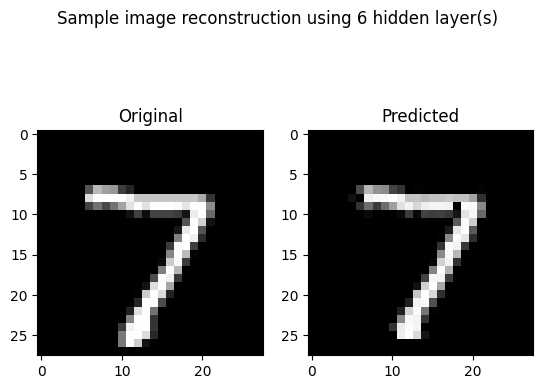

In [10]:
pretrain_history = greedy_layer_wise_pre_trainining(
    model=model,
    training_data=x_train,
    val_data=x_test,
)

In [11]:
history = model.fit(
    x=x_train,
    y=y_train_oh,
    batch_size=50,
    epochs=25,
    shuffle=True,
    validation_data=(x_test, y_test_oh),
)

Epoch 1/25
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - Accuracy: 0.8806 - F1: 0.8806 - Precision: 0.9354 - Recall: 0.8380 - loss: 0.3917 - val_Accuracy: 0.9480 - val_F1: 0.9480 - val_Precision: 0.9562 - val_Recall: 0.9386 - val_loss: 0.1727
Epoch 2/25
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - Accuracy: 0.9723 - F1: 0.9723 - Precision: 0.9771 - Recall: 0.9684 - loss: 0.0952 - val_Accuracy: 0.9787 - val_F1: 0.9787 - val_Precision: 0.9822 - val_Recall: 0.9758 - val_loss: 0.0735
Epoch 3/25
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - Accuracy: 0.9812 - F1: 0.9812 - Precision: 0.9838 - Recall: 0.9788 - loss: 0.0643 - val_Accuracy: 0.9784 - val_F1: 0.9784 - val_Precision: 0.9813 - val_Recall: 0.9764 - val_loss: 0.0747
Epoch 4/25
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - Accuracy: 0.9852 - F1: 0.9852 - Precision: 0.9874 - Recall: 0.9830 - loss: 0.0516 - val_Accuracy: 0.9741 - val_F1: 0.9741 - val_Precision: 0.9774 - val_Recall: 0.9726 - val_loss: 0.0977
Epoch 5/25
1200/1200 ━━━━

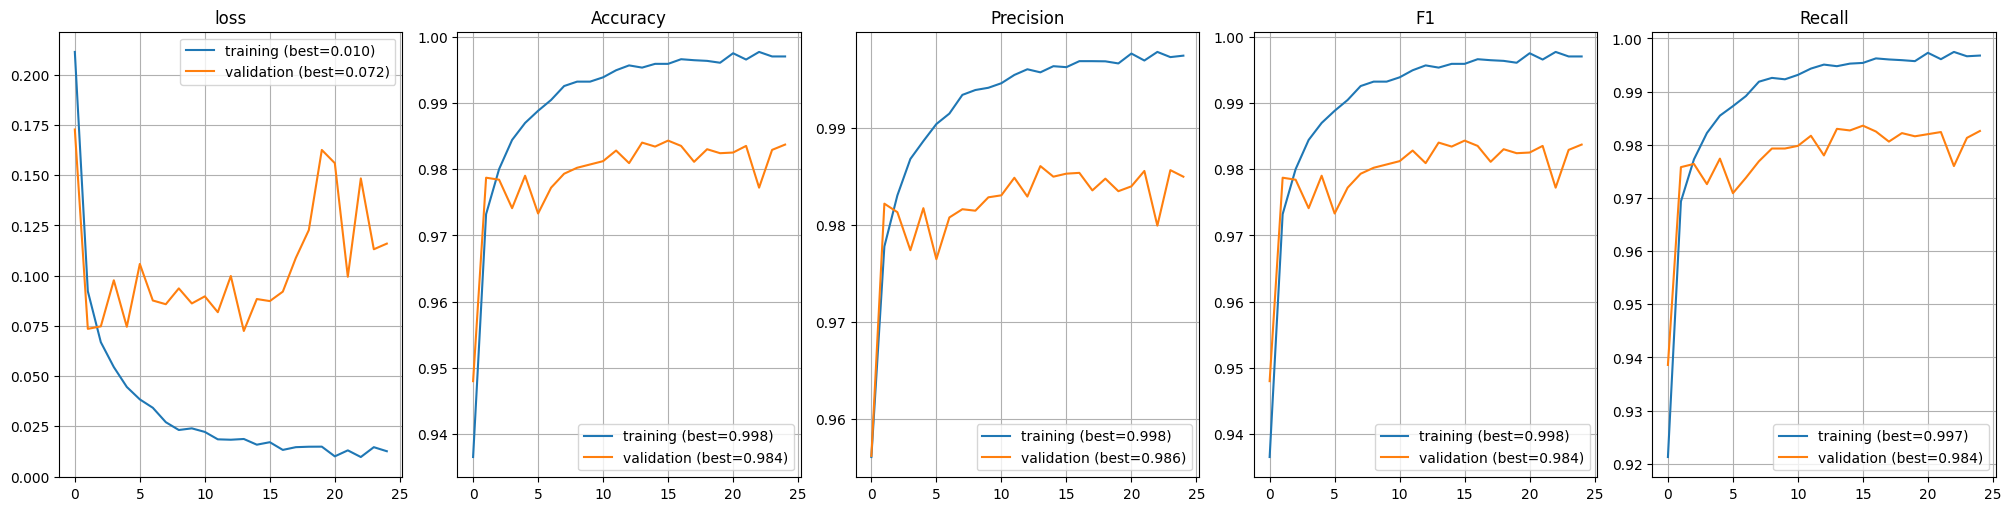

In [12]:
h_df = pd.DataFrame(history.history)

metrics = set([k.split('_')[-1] for k in history.history.keys()])

fig, axs = plt.subplots(ncols=len(metrics), nrows=1, constrained_layout=True, figsize=(20,5))

for plot_idx, metric in enumerate(metrics):
    best = h_df.max(0) if metric != 'loss' else h_df.min(0)
    axs[plot_idx].plot(
        history.history[metric],
        label=f'training (best={best[metric]:.3f})'
    )
    axs[plot_idx].plot(
        history.history['val_'+metric],
        label=f'validation (best={best["val_"+metric]:.3f})'
    )
    axs[plot_idx].grid(True)
    axs[plot_idx].set_title(metric)
    axs[plot_idx].legend()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Axes: >

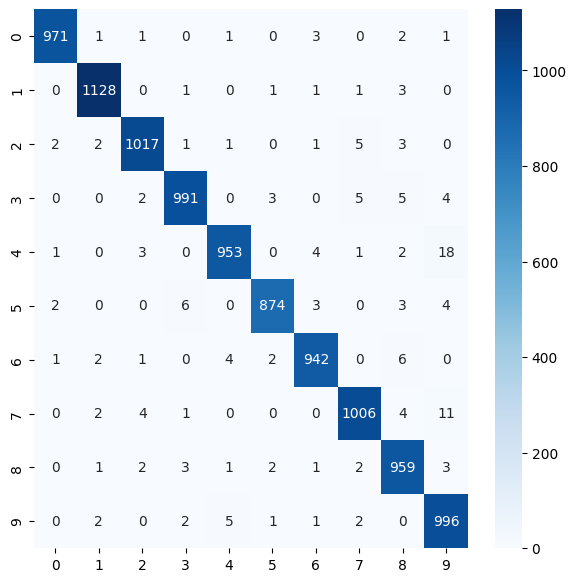

In [13]:
y_prediction = model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)

cf_matrix = confusion_matrix(y_test, y_prediction, normalize=None)

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues', ax=ax)